In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from scipy.stats import pearsonr, spearmanr, shapiro

from feature_engine.outliers import Winsorizer

In [2]:
df = pd.read_csv('./Dataset/cardekho.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [3]:
df.duplicated().sum()

1202

In [4]:
df = df.drop_duplicates().reset_index(drop=True)

In [5]:
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

df['max_power'] = df['max_power'].str.strip().replace({'':np.nan}).astype('float')
cat_cols.remove('max_power')
num_cols.append('max_power')

Categorical: ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'max_power']
Numeric: ['year', 'selling_price', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats']


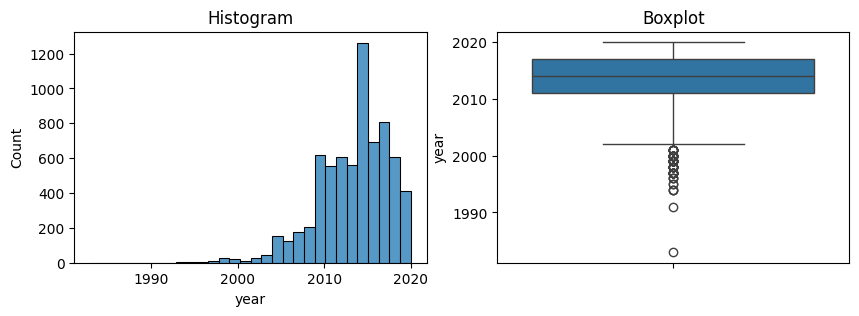

Skewness: -1.0109238235669904
Kurtosis: 1.614733878541498


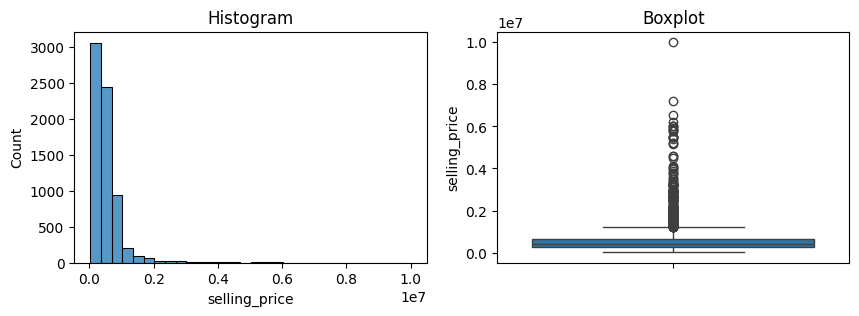

Skewness: 5.572742292649192
Kurtosis: 52.82276601297473


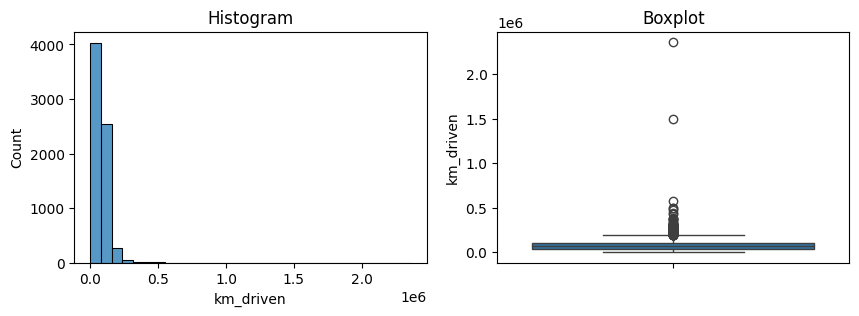

Skewness: 11.758425539599084
Kurtosis: 394.08811938521194


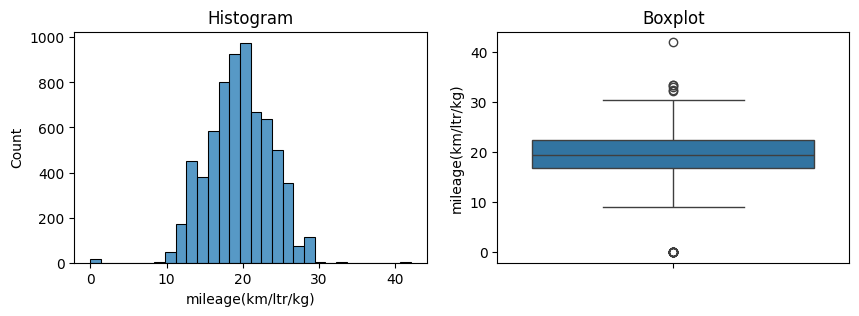

Skewness: -0.1675292102721837
Kurtosis: 0.607895308158489


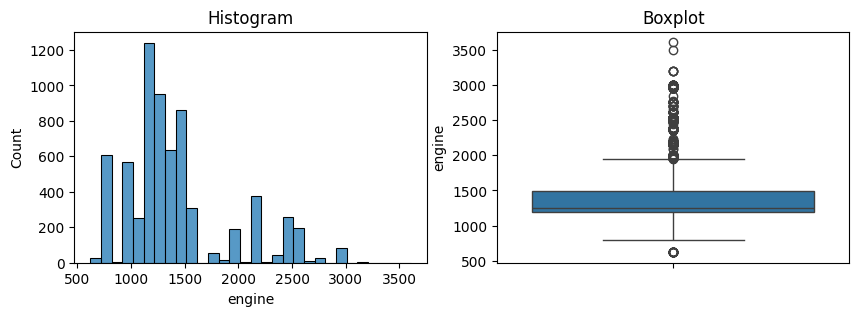

Skewness: 1.2156294419713174
Kurtosis: 0.9696204342567789


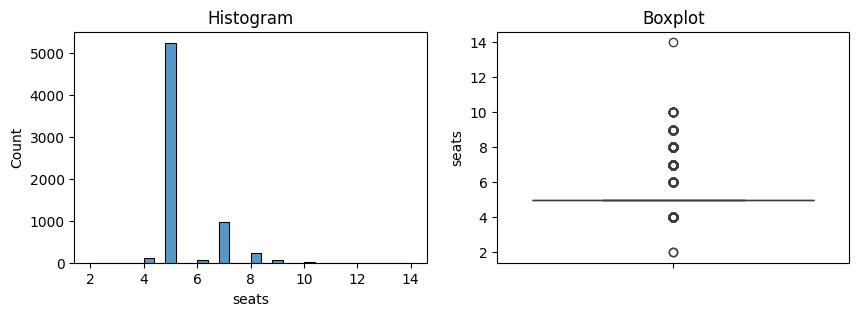

Skewness: 1.9180198914401083
Kurtosis: 3.5997410676759816


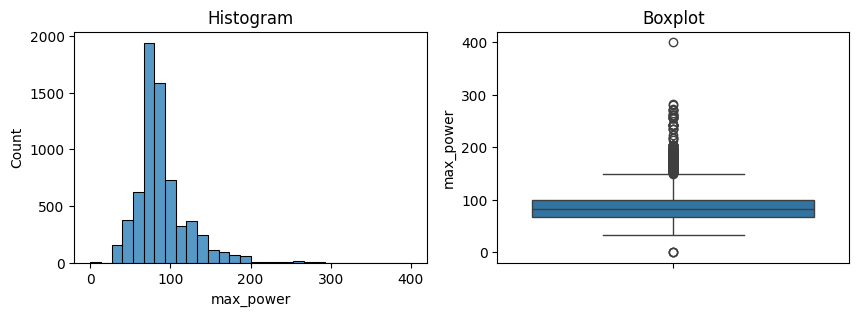

Skewness: 1.6972585962276057
Kurtosis: 5.407685767107205


In [6]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

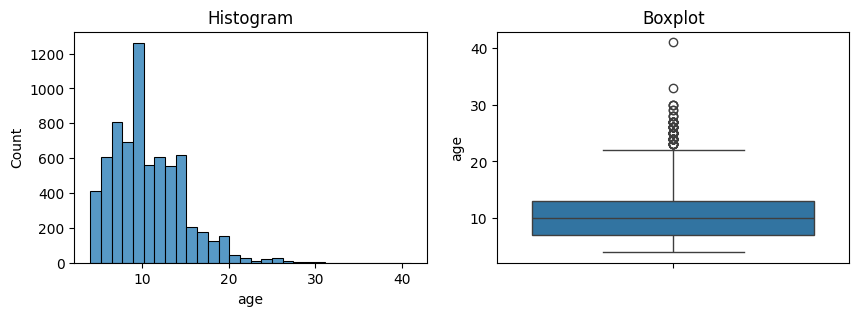

Skewness: 1.0109238235669253
Kurtosis: 1.6147338785414118


In [7]:
df['age'] = dt.now().year - df['year']
df = df.drop(columns=['year'])

num_cols[0] = 'age'
num_cols.remove('selling_price')

check_distribution_outliers(df, ['age'])

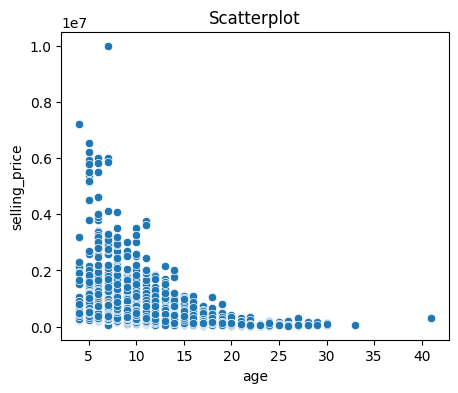

Spearman's R: -0.7050672231738586 (0.0)
Nans:  0


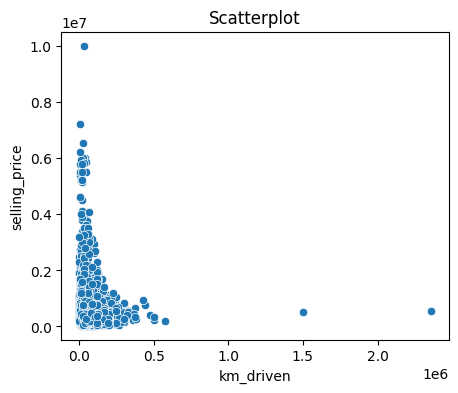

Spearman's R: -0.2892335009623044 (1.4670698388020596e-133)
Nans:  0


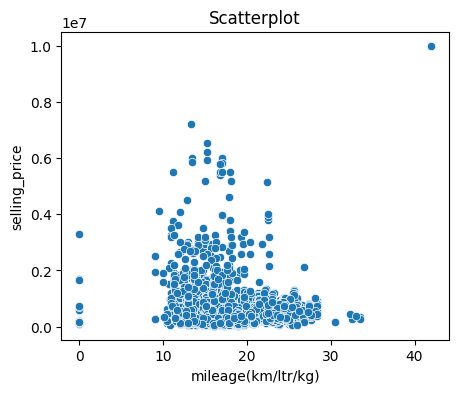

Spearman's R: 0.02517261762865377 (0.03909586577285107)
Nans:  208


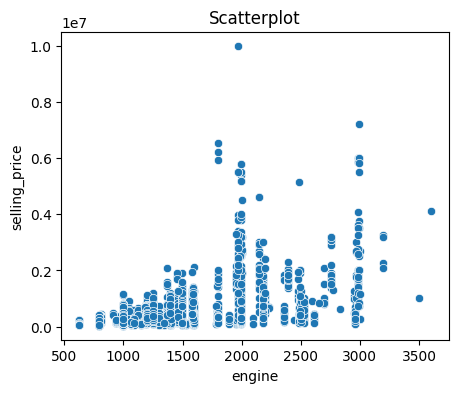

Spearman's R: 0.4824248037394133 (0.0)
Nans:  208


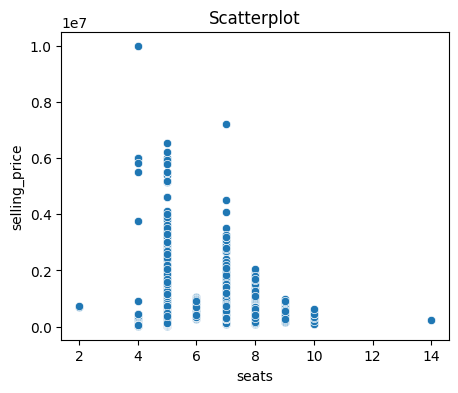

Spearman's R: 0.3187332227176408 (1.7807141566494636e-158)
Nans:  208


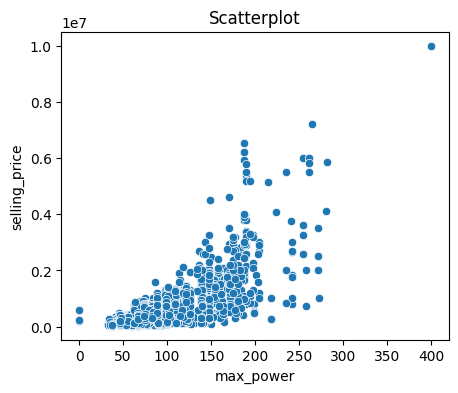

Spearman's R: 0.6343454240824176 (0.0)
Nans:  206


In [8]:
def check_correlation(df_in, x_cols, y_col):
    for col in x_cols:
        df = df_in.copy()
        df = df.dropna(subset=[col,y_col])
        plt.figure(figsize=(5, 4))

        # Histogram
        plt.subplot(1, 1, 1)
        sns.scatterplot(df, x=col, y=y_col)
        plt.title('Scatterplot')

        plt.show()

        # print('Pearson\'s R:', pearsonr(df[col],df[y_col])[0], "(" + str(pearsonr(df[col],df[y_col])[1])+")")
        print('Spearman\'s R:', spearmanr(df[col],df[y_col])[0], "(" + str(spearmanr(df[col],df[y_col])[1])+")")
        print('Nans: ',df_in[col].isna().sum())

check_correlation(df,num_cols,y_col="selling_price")

## Handling Missing Data

In [9]:
for i in df.columns:
    print(i, df[i].isna().sum())

name 0
selling_price 0
km_driven 0
fuel 0
seller_type 0
transmission 0
owner 0
mileage(km/ltr/kg) 208
engine 208
max_power 206
seats 208
age 0


#### Dropping MNAR data, Naive Approach

In [228]:
df = df.dropna(subset=['mileage(km/ltr/kg)']).reset_index(drop=True)

#### Imputing Possibly MAR Data, Naive Approach

In [229]:
# Skewed, use median
df.loc[df['max_power'].isna(),'max_power'] = df['max_power'].dropna().median()

## Encoding

In [110]:
df[cat_cols]

,name,fuel,seller_type,transmission,owner
0,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
1,Skoda Rapid 1.5 TDI Ambition,Diesel,Individual,Manual,Second Owner
2,Honda City 2017-2020 EXi,Petrol,Individual,Manual,Third Owner
3,Hyundai i20 Sportz Diesel,Diesel,Individual,Manual,First Owner
4,Maruti Swift VXI BSIII,Petrol,Individual,Manual,First Owner
...,...,...,...,...,...
7902,Hyundai i20 Magna,Petrol,Individual,Manual,First Owner
7903,Hyundai Verna CRDi SX,Diesel,Individual,Manual,Fourth & Above Owner
7904,Maruti Swift Dzire ZDi,Diesel,Individual,Manual,First Owner
7905,Tata Indigo CR4,Diesel,Individual,Manual,First Owner


In [230]:
df = df.drop(columns=['name'])
cat_cols.remove('name')

In [114]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

fuel
Diesel    4299
Petrol    3520
CNG         53
LPG         35
Name: count, dtype: int64 

seller_type
Individual          6564
Dealer              1107
Trustmark Dealer     236
Name: count, dtype: int64 

transmission
Manual       6866
Automatic    1041
Name: count, dtype: int64 

owner
First Owner             5215
Second Owner            2017
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: count, dtype: int64 



#### Transmission is Binary, Fuel and seller type are nominal. For experiment purposes, we'll treat owner as ordinal

In [195]:
nom_cols = ['fuel','seller_type']

In [231]:
ord_enc = OrdinalEncoder(categories=[['Test Drive Car','First Owner','Second Owner','Third Owner','Fourth & Above Owner']])
ohe_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
bin_enc = LabelEncoder()

In [232]:
df = df.reset_index(drop=True)
df['owner'] = ord_enc.fit_transform(df[['owner']])

In [233]:
# df = pd.concat([df,ohe_enc.fit_transform(df[nom_cols])],axis=1)
# df = df.drop(columns=nom_cols)
df['transmission'] = bin_enc.fit_transform(df[['transmission']])

c:\Users\grego\.conda\envs\torch_py310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [243]:
df = pd.concat([df.drop(columns=nom_cols),pd.get_dummies(df[nom_cols]).astype('int')],axis=1)
df.head()

,selling_price,km_driven,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,age,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,450000,145500,1,1.0,23.40,1248.0,74.00,5.0,10,0,1,0,0,0,1,0
1,370000,120000,1,2.0,21.14,1498.0,103.52,5.0,10,0,1,0,0,0,1,0
2,158000,140000,1,3.0,17.70,1497.0,78.00,5.0,18,0,0,0,1,0,1,0
3,225000,127000,1,1.0,23.00,1396.0,90.00,5.0,14,0,1,0,0,0,1,0
4,130000,120000,1,1.0,16.10,1298.0,88.20,5.0,17,0,0,0,1,0,1,0


In [244]:
ord_enc.inverse_transform(df[['owner']])

array([['First Owner'],
       ['Second Owner'],
       ['Third Owner'],
       ...,
       ['First Owner'],
       ['First Owner'],
       ['First Owner']], dtype=object)

## Winsorizing

For handling outliers

In [250]:
gauss_winsor = Winsorizer(capping_method='gaussian',
                            tail='both',
                            variables=num_cols,
                            missing_values='ignore')

iqr_winsor = Winsorizer(capping_method='iqr',
                            tail='right',
                            variables=num_cols.remove('seats'),
                            missing_values='ignore')

# X_train_capped = winsoriser_normal.fit_transform(X_train_numerical)

In [254]:
gauss_winsor.fit_transform(df[num_cols]).describe()

,age,km_driven,mileage(km/ltr/kg),engine,max_power
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,9.989266,68270.081792,19.432043,1457.794702,91.172555
std,3.763510,45484.483650,3.965825,501.043880,34.108784
min,4.000000,1.000000,7.308114,624.000000,32.800000
25%,7.000000,35000.000000,16.780000,1197.000000,68.050000
50%,9.000000,60000.000000,19.300000,1248.000000,82.000000
75%,12.000000,95750.000000,22.320000,1582.000000,102.000000
max,21.617050,239551.067614,31.529453,2970.278326,198.814733


In [253]:
iqr_winsor.fit_transform(df[num_cols]).describe()

,age,km_driven,mileage(km/ltr/kg),engine,max_power
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,9.958138,67537.036550,19.415534,1415.431200,89.205032
std,3.676207,43160.621414,4.025521,411.733385,29.141598
min,4.000000,1.000000,0.000000,624.000000,32.800000
25%,7.000000,35000.000000,16.780000,1197.000000,68.050000
50%,9.000000,60000.000000,19.300000,1248.000000,82.000000
75%,12.000000,95750.000000,22.320000,1582.000000,102.000000
max,19.500000,186875.000000,30.630000,2159.500000,152.925000


In [252]:
df[num_cols].describe()

,age,km_driven,mileage(km/ltr/kg),engine,max_power
count,7907.000000,7.907000e+03,7907.000000,7907.000000,7907.000000
mean,10.017832,6.919256e+04,19.418783,1458.625016,91.586161
std,3.866650,5.678976e+04,4.037145,503.916303,35.745118
min,4.000000,1.000000e+00,0.000000,624.000000,32.800000
25%,7.000000,3.500000e+04,16.780000,1197.000000,68.050000
50%,9.000000,6.000000e+04,19.300000,1248.000000,82.000000
75%,12.000000,9.575000e+04,22.320000,1582.000000,102.000000
max,30.000000,2.360457e+06,42.000000,3604.000000,400.000000


## Scaling

Only mileage seems normal.

In [215]:
for i in num_cols:
    print(i, shapiro(df[i]))

age ShapiroResult(statistic=0.9315519981638021, pvalue=5.984515664428457e-51)
km_driven ShapiroResult(statistic=0.6858332345898505, pvalue=5.752938679106418e-81)
mileage(km/ltr/kg) ShapiroResult(statistic=0.9891809988512673, pvalue=4.115224742295524e-24)
engine ShapiroResult(statistic=0.8761435561579871, pvalue=8.711026914741069e-62)
seats ShapiroResult(statistic=0.5576348066077814, pvalue=1.0988426093125681e-88)
max_power ShapiroResult(statistic=0.86532337066171, pvalue=2.1031437666722863e-63)


c:\Users\grego\.conda\envs\torch_py310\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7907.
  res = hypotest_fun_out(*samples, **kwds)


In [216]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

In [217]:
std_scaler.fit_transform(df[num_cols])

array([[-0.00461211,  1.34376809,  0.98620891, -0.41800262, -0.43429672,
        -0.49201889],
       [-0.00461211,  0.89471509,  0.42637197,  0.07814289, -0.43429672,
         0.33388039],
       [ 2.06449299,  1.24691352, -0.42576921,  0.0761583 , -0.43429672,
        -0.38010842],
       ...,
       [ 1.28857858,  0.89471509, -0.02942447, -0.41800262, -0.43429672,
        -0.49481665],
       [ 0.25402602, -0.77822745,  1.02832054, -0.12428448, -0.43429672,
        -0.60392936],
       [ 0.25402602, -0.77822745,  1.02832054, -0.12428448, -0.43429672,
        -0.60392936]])

In [218]:
mm_scaler.fit_transform(df[num_cols])

array([[0.23076923, 0.06164021, 0.55714286, 0.20939597, 0.25      ,
        0.11220044],
       [0.23076923, 0.05083721, 0.50333333, 0.29328859, 0.25      ,
        0.19259259],
       [0.53846154, 0.05931015, 0.42142857, 0.29295302, 0.25      ,
        0.12309368],
       ...,
       [0.42307692, 0.05083721, 0.45952381, 0.20939597, 0.25      ,
        0.1119281 ],
       [0.26923077, 0.01059075, 0.56119048, 0.2590604 , 0.25      ,
        0.10130719],
       [0.26923077, 0.01059075, 0.56119048, 0.2590604 , 0.25      ,
        0.10130719]])

In [219]:
rob_scaler.fit_transform(df[num_cols])

array([[ 0.2       ,  1.40740741,  0.7400722 ,  0.        ,  0.        ,
        -0.23564065],
       [ 0.2       ,  0.98765432,  0.33212996,  0.64935065,  0.        ,
         0.63387334],
       [ 1.8       ,  1.31687243, -0.28880866,  0.64675325,  0.        ,
        -0.11782032],
       ...,
       [ 1.2       ,  0.98765432,  0.        ,  0.        ,  0.        ,
        -0.23858616],
       [ 0.4       , -0.57613169,  0.77075812,  0.38441558,  0.        ,
        -0.35346097],
       [ 0.4       , -0.57613169,  0.77075812,  0.38441558,  0.        ,
        -0.35346097]])

In [220]:
df[num_cols] = rob_scaler.fit_transform(df[num_cols])